In [1]:
#the gym dependency issue with tensorflow was something i could not solve. had to find alternative libraries and stumbled across gymnasium
!pip install gymnasium[other]
!pip install gymnasium[classic-control]
import gymnasium as gym 
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo  

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import cv2

In [4]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
env = gym.make('CartPole-v1')
print(env.action_space)

Discrete(2)


Discrete(2) means that there are **2** possible actions
  + 0: Push cart to the left
  + 1:Push cart to the right

In [6]:
print(env.observation_space)

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


 **Box** observation type means that the space consists of continuous values typically represesented in this case as a **NumPy array**. The **(4,)** shows that there are 4 elements in the array. The values are the **lower** and **upper** bounds of the array. For example, the lower bound for **cart velocity** which is index 1 is **negative infinity** to **positive infinity**. The 4 observation values are **[cart position, cart velocity, pole angle, pole angular velocity]**

In [25]:
class QLearning:
    def __init__(self, env, buckets=(6, 6, 12, 12), num_actions=2, min_learning_rate=0.1, min_epsilon=0.1, discount_rate=0.99, decay_rate=25):
        """
        buckets: it splits the range of values that the 4 values can take into buckets so for example, if the value can take a range from -2 to +2 and, it will split it 4 ranges (-2 to -1),(-1 to 0),(0 to 1),(1 to 2)

        num_actions: the 2 possible actions, left and right

        min_learning_rate:each run the agent has to improve by at least this much

        min_epislon: minimum exploration rate

        discount_rate: the discount_rate of future rewards

        decay_rate: controls the decay rate of epislon and alpha over episodes
        """
        self.env = env
        self.buckets = buckets
        self.num_actions = num_actions
        self.Q_table = np.zeros(self.buckets + (num_actions,))
        self.min_learning_rate = min_learning_rate
        self.min_epsilon = min_epsilon
        self.discount_rate = discount_rate
        self.decay_rate = decay_rate

    def discretise_state(self, state):
        """"
        Converts a continous state into discrete index for the Q-table

        We also limit the values each of the 4 values can take. The upper bounds for the cart velocity is between -0.5 and + 0.5 and the pole angle is between -50 and +50 degree 
        """
        upper_bounds = [self.env.observation_space.high[0], 0.5,
                        self.env.observation_space.high[2], math.radians(50)]
        lower_bounds = [self.env.observation_space.low[0], -0.5,
                        self.env.observation_space.low[2], -math.radians(50)]

        ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(state))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
        return tuple(new_obs)

    def choose_action(self, state, epsilon):
        """
        This is the Epsilon strategy. We pick a random action with probably epislon to encourage exploration. Otherwise, the agent will pick the best know action with probability (1 - epislon) based on the Q-table which stores how good each action is in a state
        """
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q_table[state])

    def update_q(self, state, action, reward, new_state, alpha):
        """"
        This is the standard Q-learning update formula converted to Python code.
        """
        self.Q_table[state][action] += alpha * (reward + self.discount_rate * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def get_epsilon(self, episode):
        """
        Returns a decayed epislon based on the current episode        
        """
        return max(self.min_epsilon, min(1.0, 1.0 - math.log10((episode + 1) / self.decay_rate)))

    def get_alpha(self, episode):
        """
        Returns a decayed learning rate based on the current episode
        """
        return max(self.min_learning_rate, min(0.5, 1.0 - math.log10((episode + 1) / self.decay_rate)))

    def train(self, episodes):
        """
        Train the agent for a number of episodes. Then reset the environment, discretise the intital state then for each step, choose an action using the greedy epislon function choose_action, change the environment based on the action and discretise the new state and update the Q-value. Accumalate the reward and check if the episode is over. Track total rewards per episode and return the list of rewards.
        """
        rewards = []
        for episode in range(episodes):
            current_state, _ = self.env.reset()
            current_state = self.discretise_state(current_state)

            alpha = self.get_alpha(episode)
            epsilon = self.get_epsilon(episode)
            total_reward = 0

            done = False
            while not done:
                action = self.choose_action(current_state, epsilon)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                new_state = self.discretise_state(obs)
                self.update_q(current_state, action, reward, new_state, alpha)
                current_state = new_state
                total_reward += reward
                done = terminated or truncated

            rewards.append(total_reward)
        return rewards

    def play_episode(self):
        """"
        Plays an episode to show what is the policy right now
        """
        state, _ = self.env.reset()
        state = self.discretise_state(state)
        done = False
        while not done:
            action = self.choose_action(state, epsilon=0)
            obs, _, terminated, truncated, _ = self.env.step(action)
            state = self.discretise_state(obs)
            done = terminated or truncated


# Task 1

In [27]:
agent = QLearning(env, buckets=(6, 6, 12, 12))  
random_state, _ = env.reset()
print("Observation:", random_state)
disc_state = agent.discretise_state(random_state)
print("Discretised state:", disc_state)
chosen_action = agent.choose_action(disc_state, epsilon=0.5)
print("Chosen action:", chosen_action)

Observation: [-0.01753788 -0.04455234  0.04593967  0.01391938]
Discretised state: (2, 2, 6, 6)
Chosen action: 0


The observation shows a random initial state after the environment is resetted, then we discretise then below is the action the agent choose to take in that state. The discretised state shows the buckets the observation values are put into. It makes it easier to understand those float values at least for me. I can tell that the value at index 2 is in **top 5/6 quartile** of possible values for pole angle that I have set max for.

This shows the agent's code is **working**. It can process a state and produce a **valid action** which in this case is **move left**.

# Task 2

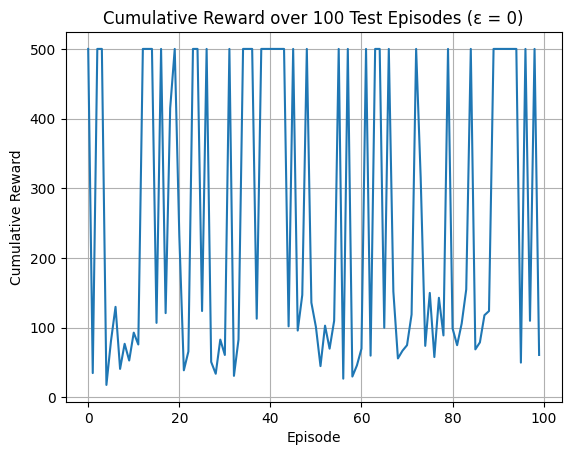

Average cumulative reward: 257.52
Is my agent good enough? True


In [34]:
env=gym.make('CartPole-v1')
agent = QLearning(env)
training_episodes = 6000
training_phase_rewards = agent.train(episodes=training_episodes) 
test_episodes = 100
test_rewards = []


for info in range(test_episodes):
    state, info = env.reset()
    state = agent.discretise_state(state)
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state, epsilon=0)  # Greedy policy
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = agent.discretise_state(next_state)
        state = next_state
        total_reward += reward
        done = terminated or truncated
    test_rewards.append(total_reward)


plt.figure()
plt.plot(test_rewards)
plt.title("Cumulative Reward over 100 Test Episodes (ε = 0)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()

avg_reward = np.mean(test_rewards)
print("Average cumulative reward:", avg_reward)
print("Is my agent good enough?", avg_reward > 195)

Here I train the agent using Q-Learning for **6000 episodes**. This is my training phase.Then for the *testing phase*, I test it over **100 episodes**, resetting it each time. The average rewards over 100 test episodes is **greater than 195**, showing the agent is a valuable learnt agent after Q-Learning

# Task 3

In [ ]:
from gymnasium.wrappers import RecordVideo


video_env = gym.make('CartPole-v1', render_mode='rgb_array')

video_env = RecordVideo(
    video_env, 
    video_folder='video', 
    episode_trigger=lambda episode_id: episode_id == 9999
)

agent = QLearning(video_env)

training_episodes = 10000
training_phase_rewards = agent.train(episodes=training_episodes)

print("Reward for the episode:", training_phase_rewards[-1])

video_env.close()


Reward for the episode: 500.0


This the video of one episode after using Q-Learning. Observe how the agent has evaluated after Q-Learning that it is better to move in one direction and to balance the pole it should counteract the direction the pole is swinging to by moving to the **opposite direction** and rewards are greedily maximised by doing this. The pole balancing for the **ideal 500 steps** confirms the agent's success.